In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, pare, Phase, Roles
import random
import copy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_recurrent_game
from notebooks.learning_agents.static_agents import random_approval_wolf, random_plurality_wolf
import notebooks.learning_agents.stats as indicators 
import networkx as nx 

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Replay visualization

We have ways to print out game replays, but humans tend to identify patterns quicker when they can visualize the data.
By plotting the game in a graph format, we give the reader yet another way to consume game replays

First we play a couple of games

In [2]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

untrained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128, 
                                        "rec_layers": 1,
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)

trained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_plurality_agent.load_state_dict(torch.load("stored_agents/lstm_first_no_one_hot_128_128/plurality_agent_10_score_46"))

# random_agent = None

trained_plurality_wins, trained_plurality_replays = play_recurrent_game(env, random_plurality_wolf, trained_plurality_agent, num_times=10, hidden_state_size=128, voting_type="plurality")

Then we use this very unoptimized function to pull out graphs for each phase in each day, and color nodes and edges accordingly. Purple is a wolf, Green is a villager. Red means you died this phase, Black means the agent was already dead during the phase.

In [10]:
def viz_replay(replay):
    #[wolf for wolf in stage["werewolves"]]
    wolves = replay[0]['werewolves']
    villagers = replay[0]['villagers']
    winners = None

    day_info = {}
    color_map = {}
    pos = None

    vote_rounds = []
    night_rounds = []
    for i, phase in enumerate(replay):
        if phase["phase"] == Phase.VOTING:
            vote_rounds.append(phase)
        if phase["phase"] == Phase.NIGHT:
            night_rounds.append(phase)
        if i == 0:

            # setup the first graph for the position and color map
            G = nx.DiGraph()
            wolf_nodes = [(id, {'color': 'purple'}) for id in wolves]
            villager_nodes = [(id, {'color': 'green'}) for id in villagers]
            G.add_nodes_from(wolf_nodes)
            G.add_nodes_from(villager_nodes)

            if pos == None:
                pos = nx.spring_layout(G)
            continue
    
        if phase['day'] not in day_info.keys():
            day_info[phase['day']] = []
            color_map[phase['day']] = []

            # 
        if phase["phase"] == Phase.VOTING:
            if len(vote_rounds) == 1:
                dead_players = []
                # dead_wolves = []
                executed_this_round = phase['executed'][0]
                killed_this_round = []
            else:
                dead_players = list((set(phase['executed']) & set(vote_rounds[-2]['executed'])) | set(phase['killed']))
                # dead_wolves = list(set(wolves) & set(dead_players))
                executed_this_round = list(set(phase['executed']) - set(vote_rounds[-2]['executed']))[0]
                killed_this_round = []

        elif phase["phase"] == Phase.NIGHT:
            if len(night_rounds) == 1:
                dead_players = phase['executed']
                executed_this_round = []
                killed_this_round = phase['killed']
            else:
                dead_players = list((set(phase['killed']) & set(night_rounds[-2]['killed'])) | set(phase['executed']))
                executed_this_round = []
                killed_this_round = list(set(phase['killed']) - set(night_rounds[-2]['killed']))[0]
        else:
            dead_players = list(set(phase['executed']) | set(phase['killed']))
            executed_this_round = []
            killed_this_round = []

        G = nx.DiGraph()
        wolf_nodes = [(id, {'color': 'purple'}) for id in wolves]
        villager_nodes = [(id, {'color': 'green'}) for id in villagers]
        G.add_nodes_from(wolf_nodes)
        G.add_nodes_from(villager_nodes)

        graph_color_map = []
        for node in G:
            if 'color' in G.nodes[node]:
                if node in dead_players:
                    graph_color_map.append('black')
                elif node in executed_this_round or node in killed_this_round:
                    graph_color_map.append('red')
                else:
                    graph_color_map.append(G.nodes[node]['color'])
            else:
                graph_color_map.append('blue')

        # edges for plurality
        if phase["phase"] == Phase.NIGHT:
            # hide villager votes
            edges = [(voter, f'player_{target}') for voter, target in phase['votes'].items() if target != len(wolves) + len(villagers) and voter not in villagers]
        else:
            edges = [(voter, f'player_{target}') for voter, target in phase['votes'].items() if target != len(wolves) + len(villagers)]
        G.add_edges_from(edges)

        day_info[phase['day']].append(G)
        color_map[phase['day']].append(graph_color_map)

    return day_info, pos, color_map

viz_info, pos, cmap = viz_replay(trained_plurality_replays[0])

This loose piece of code takes in the output of our function and actually draws out the game in a matplotlib subplot graph with rows representing incrementing days, and columns representing incrementing phases.

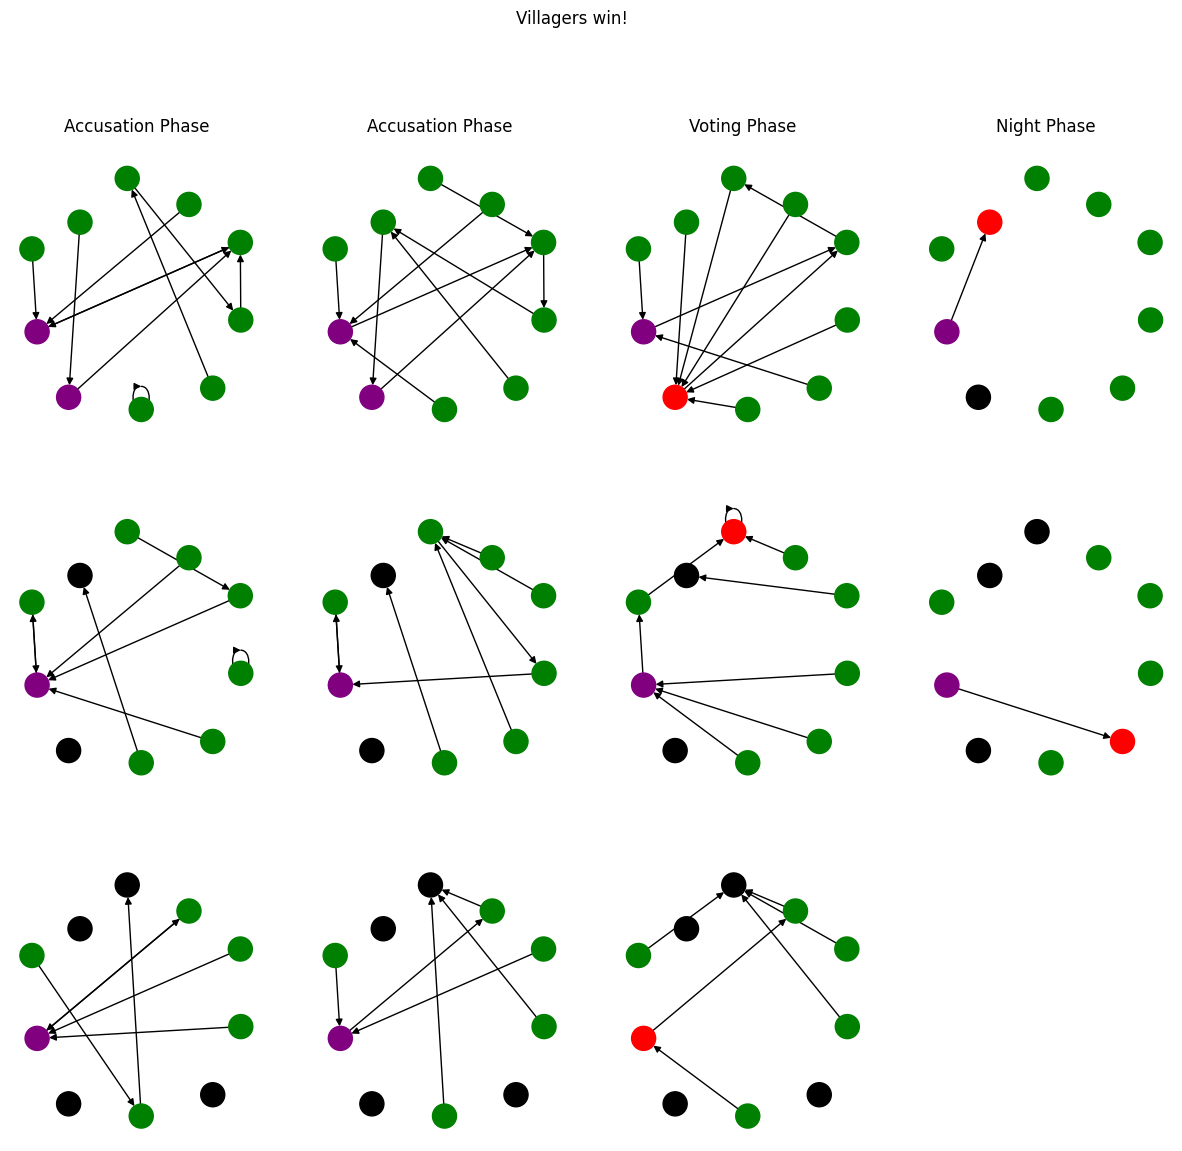

In [24]:
# TODO: clean this up, maybe use newer matplotlib 3.4 subplots and put it in the viz_info function

day_num = len(viz_info.keys())
phases_per_day = max([len(val) for val in viz_info.values()])
pad = 5

phase_map = list(range(phases_per_day))
phase_range_accusation = phase_map[0:-2]

fig, axs = plt.subplots(day_num,phases_per_day, figsize=(15,13), sharey=True, sharex=True)

for day in range(1,day_num+1):
    
    for j, graph in enumerate(viz_info[day]):
        if day == 1:
            if j in phase_range_accusation:
                title = f'Accusation Phase'
            elif j == phase_map[-2]:
                title = f'Voting Phase'
            elif j == phase_map[-1]:
                title = f'Night Phase'
            axs[day-1][j].set_title(title)
        nx.draw(viz_info[day][j], pos, ax=axs[day-1][j], node_color=cmap[day][j])
    

day_phase_lengths = [len(val) for val in viz_info.values()]
if day_phase_lengths[-1] < day_phase_lengths[-2]:
    axs[-1][-1].axis('off')
    plt.suptitle("Villagers win!")
else:
    plt.suptitle("Wolves win!")

# fig.tight_layout()
plt.show()
